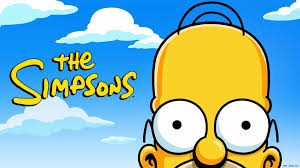

In [1]:

# Importar librerías necesarias
from collections import Counter
from itertools import tee, islice
from matplotlib import pyplot as plt
from matplotlib.cbook import get_sample_data
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from PIL import Image
from plotly import tools
from plotly.offline import init_notebook_mode, iplot, plot
import plotly.graph_objs as go
from plotly import express as px
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from wordcloud import WordCloud, STOPWORDS
import cufflinks as cf
import gensim
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import networkx as nx
import nltk
import numpy as np
import pandas as pd
import plotly
import random
import re
import seaborn as sns

# Descargar recursos necesarios de NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('wordnet')

# Configuración adicional
%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Voy a realizar un analisis de un dataset con los dialogos de los simpsons. El analisis contara de dos momentos. En una primera etapa analizare los dialogos segun cada personaje principal. EN una segunda etapa analizare cada capitulo e intentare relacionar un analisis de sentimiento con el puntaje de valoracion de cada capitulo

## Carga de Datos

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/Havilongo/NLP/main/Simpsons/Data/simpsons_script_lines.csv', index_col= [0])


<ipython-input-2-a9b55c775dfa>:1: DtypeWarning:

Columns (5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.



In [3]:
df.shape

(158248, 13)

In [4]:
df.sample()

id  episode_id  number  \
index                                
140595  151041         540     151   

                                                 raw_text timestamp_in_ms  \
index                                                                       
140595  (The Android's Dungeon & Baseball Card Shop: e...          854000   

       speaking_line character_id  location_id raw_character_text  \
index                                                               
140595         false          NaN        396.0                NaN   

                                 raw_location_text spoken_words  \
index                                                             
140595  The Android's Dungeon & Baseball Card Shop          NaN   

       normalized_text  word_count  
index                               
140595             NaN         NaN

Columnas del dataset:

- **id**: valor unico para cada fila
- **episode_id**: un codigo referencia del episodio
- **raw_text**: dialogo crudo. Quien lo dice, seguido del dialogo
- **timestamp_in_ms**: cuando tiene lugar el dialogo dentro del episodio
- **speaking_line**: aclara si en esa linea hay una linea de dialogo o no.
- **character_id**: codigo de referencia de los personajes
- **location_id**: codigo de referencia de los lugares
- **raw_character_text**: Nombre del personaje que dice el dialogo
- **raw_location_text**: Lugar donde se lleva a cabo el dialogo
- **spoken_words**: Dialogo de cada personaje
- **normalized_text**: Texto normalizado (no voy a usarlo)
- **word_count**: conteo del numero de palabras (no voy a usarlo)


La columna 'Speaking_line' aclara si en esa linea hay una linea de dialogo o no.
Voy a proceder a quedarme con los true de esa columna para proceder con mi analisis.

In [5]:
df['speaking_line'].unique()

array([True, False, 'true', 'false',
       'Guess what. I also play Frankenstein!'], dtype=object)

In [6]:
line = {'true': 'True'
        , 'false': 'False'
        , 'True': 'True'
        , 'False': 'False'
        , 'Guess what. I also play Frankenstein!' : 'False'
       }

df['speaking_line'] = df.speaking_line.map(line)


In [7]:
df2 = df.loc[df['speaking_line'] == 'True']

In [8]:
# Analizo los que deje
vacios = df.loc[df['speaking_line'] == 'False']
vacios.shape

(4115, 13)

In [9]:
vacios['spoken_words'].isna().sum()

4115

Ninguno de los que deje afuera tienen dialogos

In [10]:
df2.sample()

id  episode_id  number  \
index                              
153442  4722          16     134   

                                                 raw_text timestamp_in_ms  \
index                                                                       
153442  Lisa Simpson: Look, I know that to you we Simp...          643000   

       speaking_line character_id  location_id raw_character_text  \
index                                                               
153442          True            9        221.0       Lisa Simpson   

       raw_location_text                                       spoken_words  \
index                                                                         
153442        Spacecraft  Look, I know that to you we Simpsons are a low...   

                                          normalized_text  word_count  
index                                                                  
153442  look i know that to you we simpsons are a lowe...        41.0

Chequeo los tipos de los datos

In [11]:
df2.dtypes

id                      int64
episode_id              int64
number                  int64
raw_text               object
timestamp_in_ms        object
speaking_line          object
character_id           object
location_id           float64
raw_character_text     object
raw_location_text      object
spoken_words           object
normalized_text        object
word_count            float64
dtype: object

Veo si hay nulos

In [12]:
df2.isna().sum()

id                     0
episode_id             0
number                 0
raw_text               0
timestamp_in_ms        0
speaking_line          0
character_id           1
location_id           41
raw_character_text     1
raw_location_text     41
spoken_words           0
normalized_text       10
word_count             0
dtype: int64

La columna raw_location_text contiene donde se lleva a cabo la linea de dialogo. Tiene 41 na, voy a reemplazarlos por locacion desconocida.

In [13]:
df2['raw_location_text'].fillna("unkwown", inplace=True)

In [14]:
df2 = df2.dropna(subset=['character_id'])

In [15]:
df2['normalized_text'] = df2['normalized_text'].astype(str)
df2['spoken_words'] = df2['spoken_words'].astype(str)

In [16]:
df2.sample()

id  episode_id  number  \
index                              
150873  2112           7     262   

                                                 raw_text timestamp_in_ms  \
index                                                                       
150873  Beautiful French Scientist: I disagree. I thin...         1276000   

       speaking_line character_id  location_id          raw_character_text  \
index                                                                        
150873          True          137        129.0  Beautiful French Scientist   

         raw_location_text                                       spoken_words  \
index                                                                           
150873  SCIENCE LABORATORY  I disagree. I think eet eez a man. Ze eyes had...   

                                          normalized_text  word_count  
index                                                                  
150873  i disagree i think eet eez a man ze eyes had a...        16.0

In [17]:
# Me quedo con las columnas que me interesan para el analisis
SC = df2[['id','episode_id','raw_character_text','raw_location_text','spoken_words']]
SC

id  episode_id raw_character_text              raw_location_text  \
index                                                                          
131072  141387         505       Bart Simpson                    CRUISE SHIP   
131074  141389         505            Steward                    CRUISE SHIP   
131076  141391         505       Bart Simpson                    CRUISE SHIP   
131078  141393         505       Bart Simpson                    CRUISE SHIP   
131079  141394         505      Marge Simpson                    CRUISE SHIP   
...        ...         ...                ...                            ...   
158243    9544          32        Miss Hoover  Springfield Elementary School   
158244    9545          32        Miss Hoover  Springfield Elementary School   
158245    9546          32        Miss Hoover  Springfield Elementary School   
158246    9547          32       Ralph Wiggum  Springfield Elementary School   
158247    9548          32              JANEY  Springfield Elementary School   

                                             spoken_words  
index                                                      
131072                                           Upgrade!  
131074  I'm sorry, there's been a mistake. This isn't ...  
131076                                    Double upgrade!  
131078                     I knew it. It was all a dream.  
131079  No, honey. You just passed out when you saw th...  
...                                                   ...  
158243                                          I'm back.  
158244  You see, class, my Lyme disease turned out to ...  
158245                                 Psy-cho-so-ma-tic.  
158246                     Does that mean you were crazy?  
158247                  No, that means she was faking it.  

[23060 rows x 5 columns]

In [18]:
SC.shape

(23060, 5)

## Preprocesamiento NLP
- primero voy a pasar a minuscula y sacar caracteres especiales de las columnas


In [19]:
# Función para eliminar caracteres especiales y pasar a minúsculas
def limpiar_texto(texto):
    texto_limpio = re.sub(r'[^a-zA-Z\s]', '', texto)  # Elimina caracteres especiales, excepto letras y espacios
    return texto_limpio.lower()  # Convierte el texto a minúsculas

In [20]:
# Aplicar la función a la columna raw_character_text
SC['character'] = SC['raw_character_text'].apply(limpiar_texto)

# Aplicar la función a la columna raw_location_text
SC['location'] = SC['raw_location_text'].apply(limpiar_texto)


# Aplicar la función a la columna raw_location_text
SC['normalizado'] = SC['spoken_words'].apply(limpiar_texto)

In [21]:

# Mostrar el DataFrame
print(SC[['raw_character_text', 'character']])

print('+*+*+*+*+*+*+*+**++*+**+*+*+')

print(SC[['raw_location_text', 'location']])




       raw_character_text      character
index                                   
131072       Bart Simpson   bart simpson
131074            Steward        steward
131076       Bart Simpson   bart simpson
131078       Bart Simpson   bart simpson
131079      Marge Simpson  marge simpson
...                   ...            ...
158243        Miss Hoover    miss hoover
158244        Miss Hoover    miss hoover
158245        Miss Hoover    miss hoover
158246       Ralph Wiggum   ralph wiggum
158247              JANEY          janey

[23060 rows x 2 columns]
+*+*+*+*+*+*+*+**++*+**+*+*+
                    raw_location_text                       location
index                                                               
131072                    CRUISE SHIP                    cruise ship
131074                    CRUISE SHIP                    cruise ship
131076                    CRUISE SHIP                    cruise ship
131078                    CRUISE SHIP                    cruise shi

In [22]:
print(SC[['spoken_words','normalizado']])

                                             spoken_words  \
index                                                       
131072                                           Upgrade!   
131074  I'm sorry, there's been a mistake. This isn't ...   
131076                                    Double upgrade!   
131078                     I knew it. It was all a dream.   
131079  No, honey. You just passed out when you saw th...   
...                                                   ...   
158243                                          I'm back.   
158244  You see, class, my Lyme disease turned out to ...   
158245                                 Psy-cho-so-ma-tic.   
158246                     Does that mean you were crazy?   
158247                  No, that means she was faking it.   

                                              normalizado  
index                                                      
131072                                            upgrade  
131074  im sorry theres be

### Analisis grafico de personajes que mas dialogos tienen

In [23]:
# Agrupar por la columna 'name' y contar el número de ocurrencias
personajes_top = SC.groupby('character').size().reset_index(name='count')

# Ordenar por la columna 'count' de manera descendente
personajes_top = personajes_top.sort_values(by='count', ascending=False)

Grafico

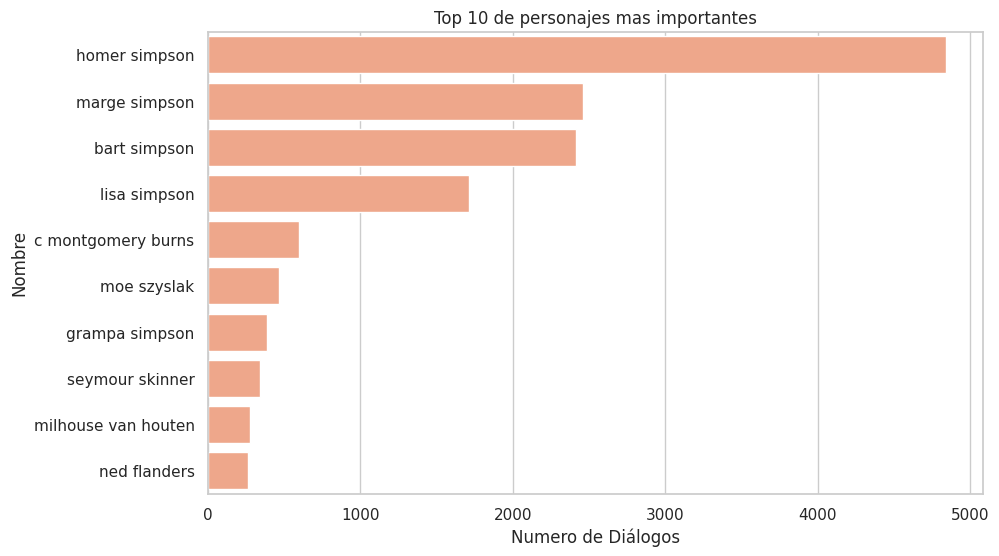

In [24]:
# Definir los colores
fillColor = "#FFA07A"

# Selecciona las 10 primeras filas y ordena por 'n'
personajes_diez = personajes_top.head(10)

# Configura el estilo del gráfico
sns.set(style="whitegrid")

# Crea el gráfico
plt.figure(figsize=(10, 6))
barplot = sns.barplot(data=personajes_diez, y='character', x='count', color=fillColor, errorbar=None)

# Configura las etiquetas y el título
plt.xlabel('Numero de Diálogos')
plt.ylabel('Nombre')
plt.title('Top 10 de personajes mas importantes')

# Muestra el gráfico
plt.show()

Los personajes que mas dialogos tienen son los que forman la familia simpson. El mas importante es Homero. Lisa es la que menos dialogos tiene de la familia.

Despues la lista la conforman el jefe de Homero, el cantinero de Homero, el papa de Homero, el director de la escuela, el mejor amigo de Bart y el vecino de la familia

### Proximos 10 personajes mas activos de la serie

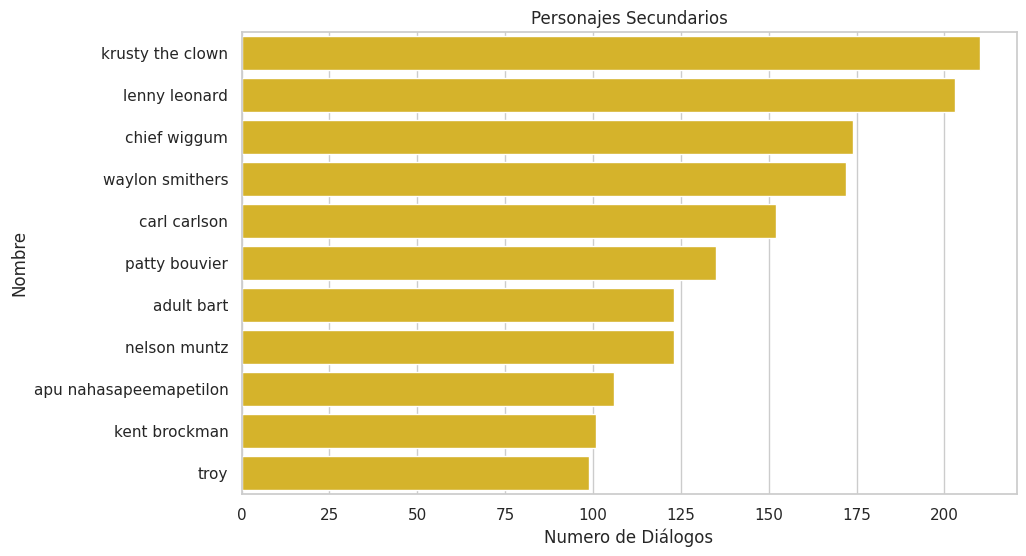

In [25]:
# Definir los colores
fillColor2 = "#F1C40F"

# Configura el estilo del gráfico
sns.set(style="whitegrid")

# Crea el gráfico
plt.figure(figsize=(10, 6))
barplot = sns.barplot(data=personajes_top.iloc[10:21], y='character', x='count', color=fillColor2, errorbar=None)

# Configura las etiquetas y el título
plt.xlabel('Numero de Diálogos')
plt.ylabel('Nombre')
plt.title('Personajes Secundarios')

# Muestra el gráfico
plt.show()

Todos estos pueden considerarse personajes secundarios de la serie

## Tokenizar palabras

In [26]:
# Creo una lista de palabras que no aportan
stop_words = []
stopwords_corpus = nltk.corpus.stopwords
eng_stop_words = stopwords_corpus.words('english')
stop_words.extend(eng_stop_words)
stop_words.extend(["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would','im', 'youre', 'youll', 'ill', 'ive', 'dont' , 'doesnt' ,'hes', 'thats', 'theres', 'id', 'cant', 'couldnt', 'shes']) # agrego las que vayan apareciendo en el analisis

In [27]:
def process_text(text):
    tokens = word_tokenize(text)  # Tokenizar y pasar a minúsculas
    return [word for word in tokens if word.isalpha() and word not in stop_words]

In [28]:
SC['tokens'] = SC['normalizado'].apply(process_text)

In [29]:
SC.sample()

id  episode_id raw_character_text raw_location_text  \
index                                                             
132223  142538         509        N.Y. Mother    Bart's Bedroom   

           spoken_words  character       location     normalizado  \
index                                                               
132223  New York style!  ny mother  barts bedroom  new york style   

                    tokens  
index                       
132223  [new, york, style]

### Analisis de Palabras
#### Las 15 palabras más comunes

In [30]:
# Crear una lista de todas las palabras
all_words = [word for tokens in SC['tokens'] for word in tokens]

# Contar las palabras
word_counts = Counter(all_words)

# Convertir a DataFrame y ordenar
word_counts_df = pd.DataFrame(word_counts.items(), columns=['word', 'count']).sort_values(by='count', ascending=False)

# Seleccionar las 15 palabras más frecuentes
top_words = word_counts_df.head(15)

# Mostrar el resultado
print(top_words)

       word  count
70       oh   1289
196    well   1193
52     like   1023
170     one    959
357    know    927
124     get    895
618   homer    787
237     got    765
215   right    696
395    bart    665
351     hey    648
89       go    608
234    good    569
286  little    559
510   think    534


De un primer analisis veo palabras como im dont youre que voy a agregar a sttopwords

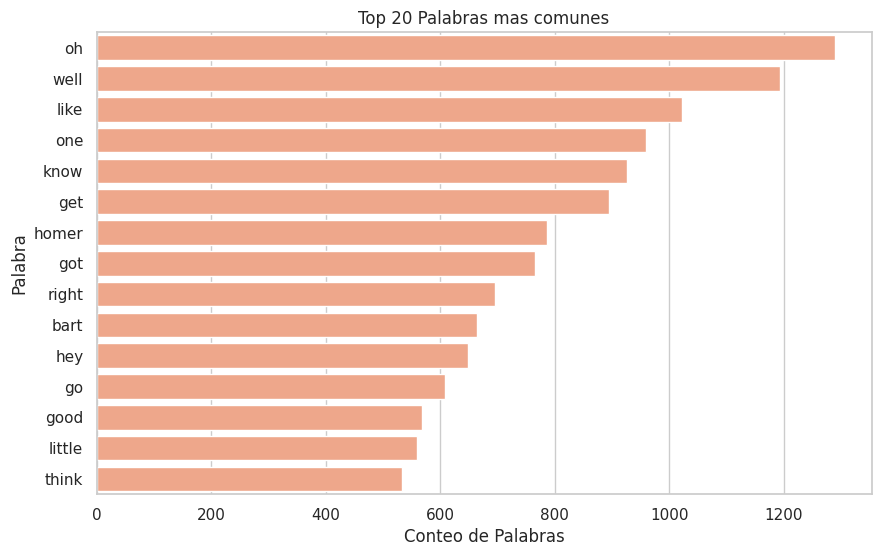

In [31]:
# Configura el estilo del gráfico
sns.set(style="whitegrid")

# Crea el gráfico
plt.figure(figsize=(10, 6))
barplot = sns.barplot(data=top_words, y='word', x='count', color=fillColor, errorbar=None)


# Configura las etiquetas y el título
plt.xlabel('Conteo de Palabras')
plt.ylabel('Palabra')
plt.title('Top 20 Palabras mas comunes')

# Muestra el gráfico
plt.show()

###  WordCloud de todas las palabras

1154425


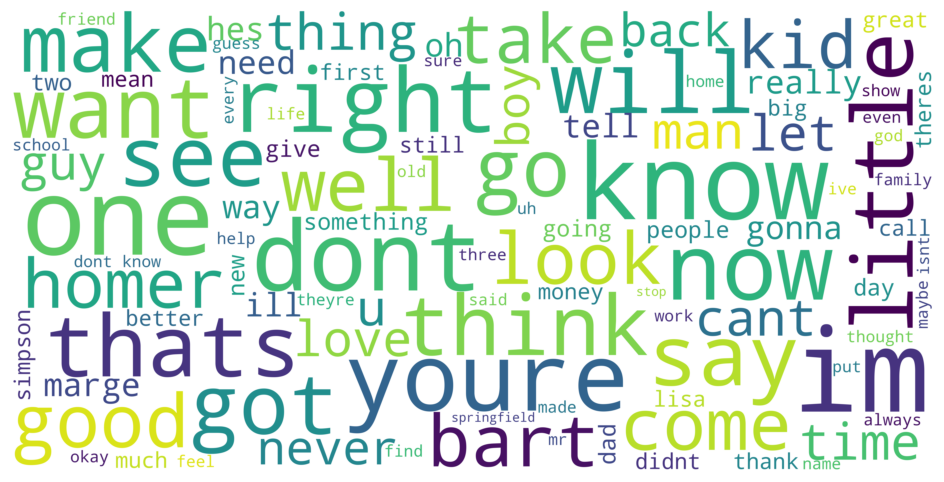

In [32]:
word_cloud_text = ''.join(SC.normalizado)
print(len(word_cloud_text))

wordcloud = WordCloud(
    max_font_size=100,
    max_words=100,
    background_color="white",
    scale=10,
    width=800,
    height=400
).generate(word_cloud_text)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

###  WordCloud de las palabras filtradas con la funcion stopword de wordcluod

1154425


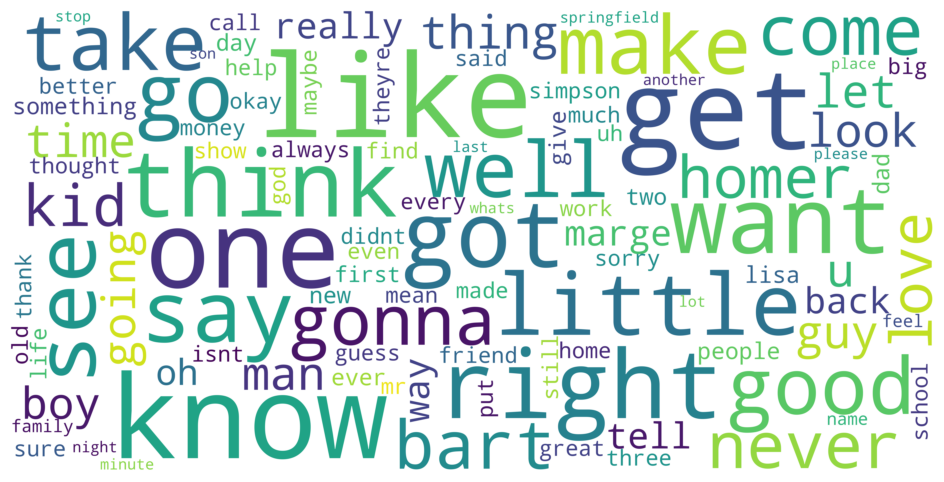

In [33]:

word_cloud_text = ''.join(SC.normalizado)
print(len(word_cloud_text))

wordcloud = WordCloud(
    max_font_size=100,
    max_words=100,
    background_color="white",
    scale=10,
    stopwords=stop_words,
    width=800,
    height=400
).generate(word_cloud_text)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### WordCloud para la cada personaje de la familia Simpson

In [34]:
# Tokenizar y contar palabras para un personaje específico
def generate_wordcloud(name_of_character):

    # Filtrar por el personaje
    character_tokens = SC[SC['character'] == name_of_character]['tokens']

    # Filtrar stopwords y contar la frecuencia de palabras
    all_words = [word for tokens in character_tokens for word in tokens if word.isalnum() and word not in stop_words]
    word_freq = pd.Series(all_words).value_counts()

    # Limitar al top 30 palabras
    word_freq = word_freq.head(30)

    # Crear la nube de palabras
    plt.figure(figsize=(10, 8))
    wordcloud = WordCloud(width=800, height=400, max_words=50, colormap='Dark2').generate_from_frequencies(word_freq)

    # Mostrar la nube de palabras
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud para {name_of_character}')
    plt.show()



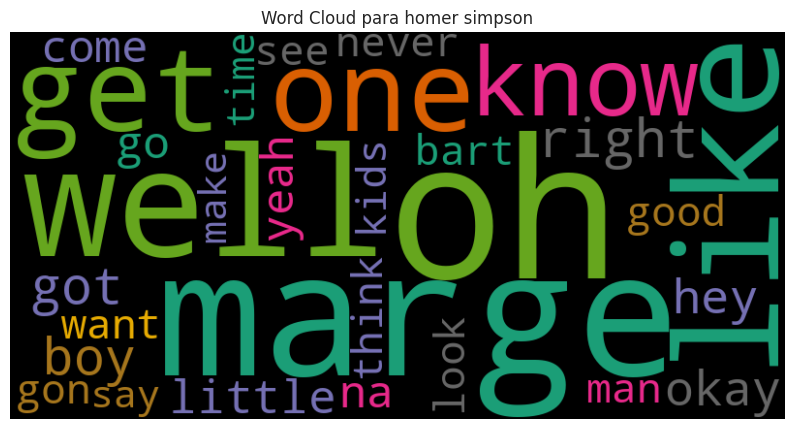

In [35]:
generate_wordcloud('homer simpson')

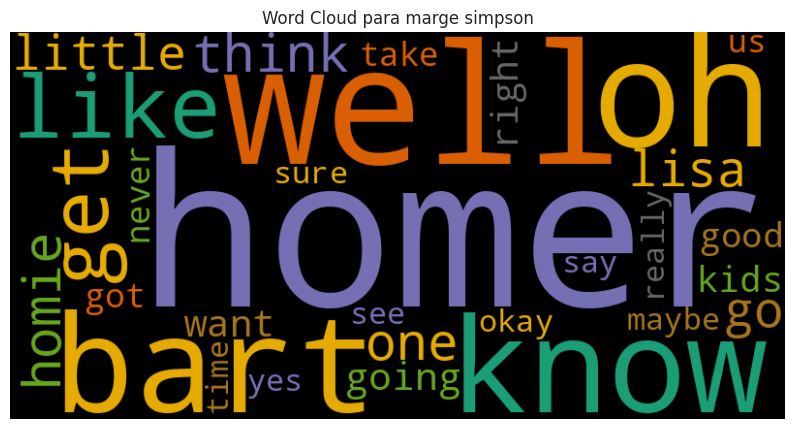

In [36]:
generate_wordcloud('marge simpson')


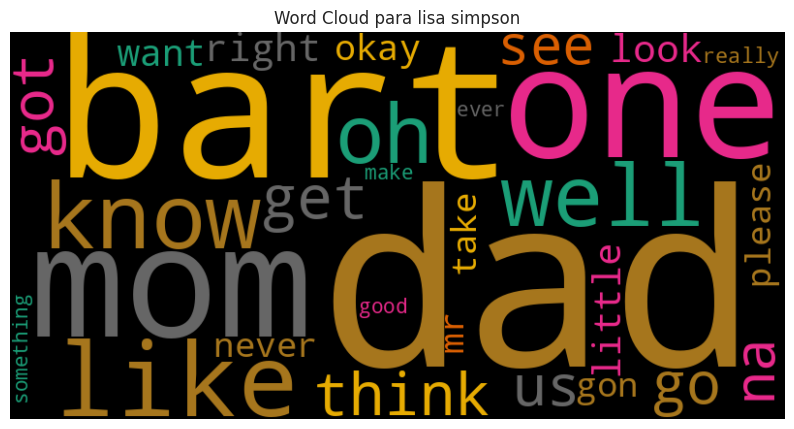

In [37]:
generate_wordcloud('lisa simpson')

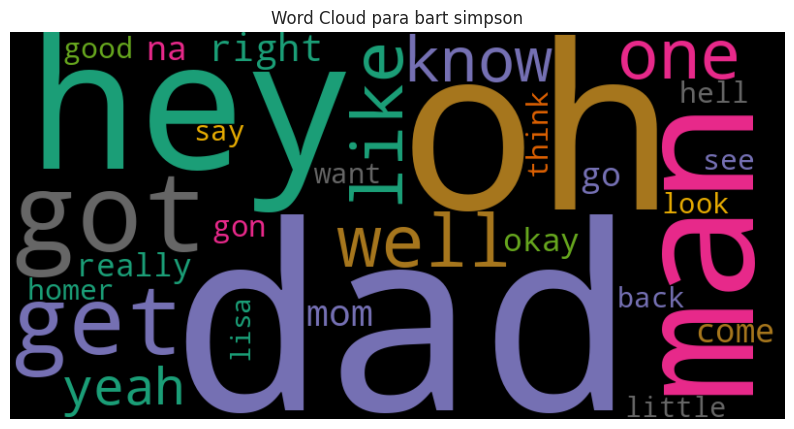

In [38]:
generate_wordcloud('bart simpson')

Las palabras mas usadas por los personajes en general son los miembros de la familia. Para Homero es Marge, oh (signo de queja), bueno y gustar. Para Marge es su familia y la palabra bueno. Para Lisa es Bart, papa y mama. Para Bart es papa y varias muletillas del personaje.

### Bigramas con CounterVectorizer

In [39]:
counter=CountVectorizer(stop_words=stop_words)

In [40]:
X=SC['normalizado']

In [41]:
X_t=counter.fit_transform(X)

In [42]:
data=pd.DataFrame(X_t.toarray().sum(axis=0),index=counter.get_feature_names_out(),columns=['freq'])

In [43]:
data.sort_values('freq',ascending=False).head(10)

freq
oh     1289
well   1193
like   1023
one     959
know    927
get     895
homer   787
right   696
bart    665
hey     648

In [44]:
X

index
131072                                              upgrade
131074    im sorry theres been a mistake this isnt your ...
131076                                       double upgrade
131078                         i knew it it was all a dream
131079    no honey you just passed out when you saw the ...
                                ...                        
158243                                              im back
158244       you see class my lyme disease turned out to be
158245                                        psychosomatic
158246                        does that mean you were crazy
158247                      no that means she was faking it
Name: normalizado, Length: 23060, dtype: object

In [45]:
text =''.join(SC['normalizado'])

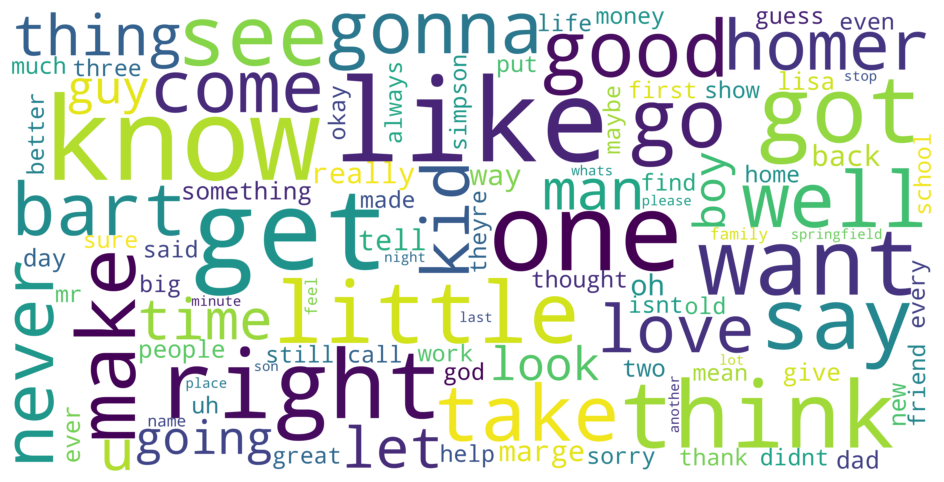

In [46]:
wordcloud = WordCloud(
    max_font_size=100,
    max_words=100,
    background_color="white",
    scale=10,
    stopwords=stop_words,
    width=800,
    height=400
).generate(text)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [47]:
# Bigramas
counter=CountVectorizer(stop_words=list(stop_words),ngram_range=(2,2))

In [48]:
X_t=counter.fit_transform(X)

In [49]:
pd.DataFrame(X_t.toarray().sum(axis=0),index=counter.get_feature_names_out(),columns=['freq']).sort_values('freq',ascending=False)


freq
homer simpson    99
mr burns         89
oh god           82
oh yeah          79
wait minute      76
...             ...
guy mean          1
guy make          1
guy made          1
guy lunch         1
lost ships        1

[78372 rows x 1 columns]

In [50]:
text2=' '.join([x.replace(' ','_') for x in counter.vocabulary_.keys()])

In [51]:
text2

'sorry_mistake mistake_isnt isnt_cabin double_upgrade knew_dream honey_passed passed_saw saw_private private_bedroom bedroom_triple triple_upgrade actually_perfect perfect_vacation never_guess guess_many many_bath bath_towels towels_gave gave_us us_enough greetings_cruisers cruisers_cruise cruise_director director_rowan rowan_priddis priddis_welcome welcome_aboard aboard_royalty royalty_valhalla valhalla_rule rule_always always_fun every_catered catered_toddlers toddlers_club club_condolences condolences_awardwinning awardwinning_luxury luxury_morgue enjoyment_pays pays_salary salary_sense sense_bossand bossand_bossid bossid_like like_ask ask_week week_vacation week_spend spend_cruiseperforming cruiseperforming_normal normal_duties duties_cruise cruise_directorthats directorthats_much much_love love_job bon_voyage whoa_fun fun_schedule schedule_much much_lasertag lasertag_waterslide waterslide_bobsled bobsled_oh oh_ice ice_cream cream_snowball snowball_fight fight_starts starts_five fi

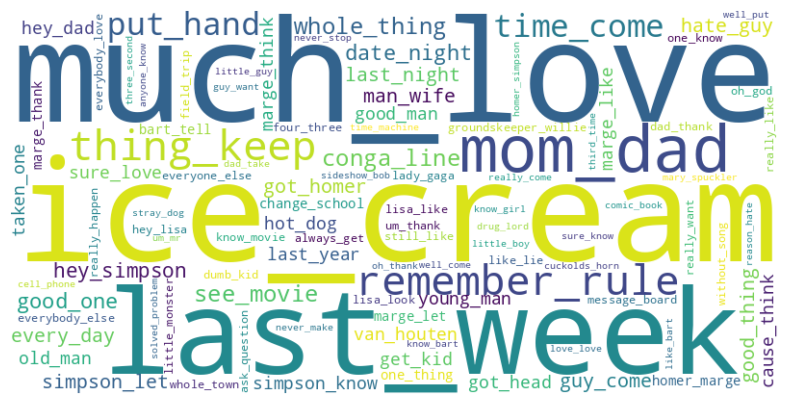

In [52]:
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white', max_words = 100,
).generate(text2)

# Display the word cloud using Matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Remove the axis
plt.show()

### Localizacion de los personajes

In [53]:
# Agrupación y conteo
location_characters = SC.groupby(['character', 'location']).size().reset_index(name='n')

In [54]:
# Definir función para la visualización de ubicaciones
def location_of_characters(name_of_character):
    # Filtrar las ubicaciones del personaje y ordenar por el conteo
    sc_location = location_characters[location_characters['character'] == name_of_character].sort_values(by='n', ascending=False).head(10)

    # Título del gráfico
    title_plot = f"Lugares favoritos de {name_of_character}"

    # Crear gráfico de barras
    plt.figure(figsize=(10, 6))
    sns.barplot(x='n', y='location',  hue = 'location',
                data=sc_location, edgecolor="white", legend = False)


    # Configurar etiquetas y título del gráfico
    plt.xlabel('Conteo de Locaciones')
    plt.ylabel('Locaciones')
    plt.title(title_plot)
    #plt.gca().invert_yaxis()  # Invertir el eje y para que sea similar a coord_flip() en ggplot2
    plt.show()

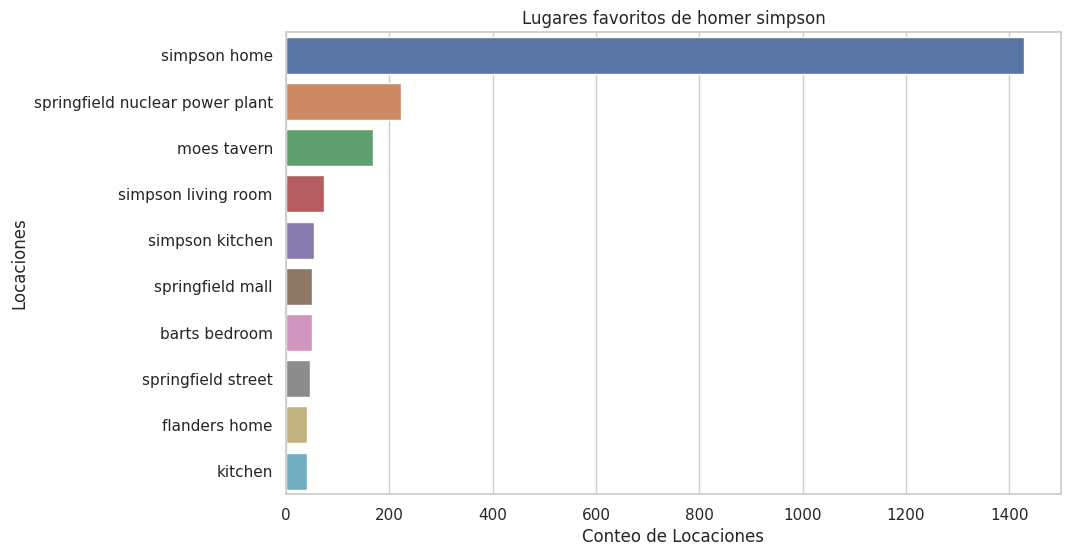

In [55]:
# Donde suceden las escenas de Homero
location_of_characters("homer simpson")

La mayoria de escenas de Homero Simpson Suceden en su casa, luego en su trabajo y tercero en el bar.

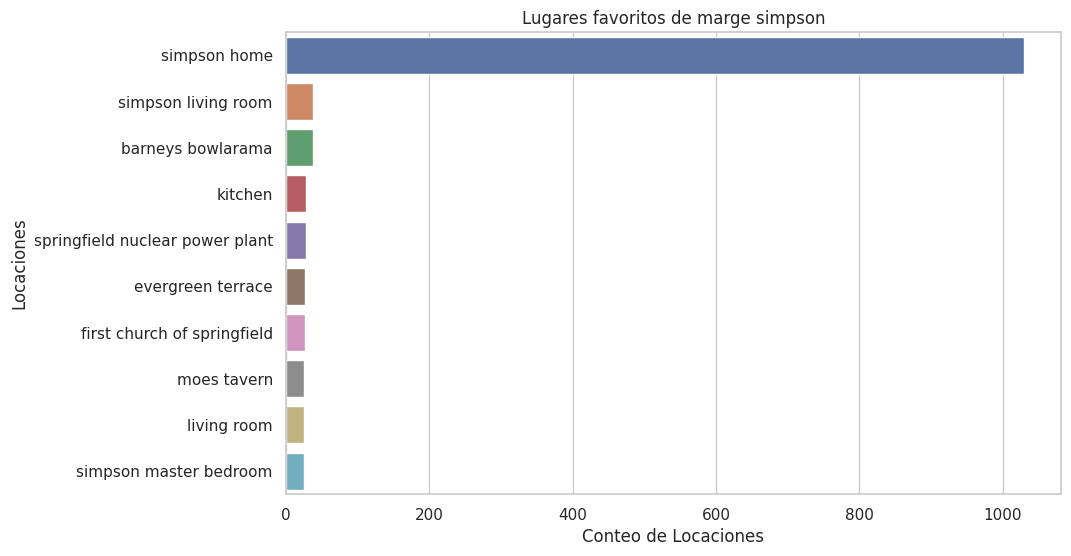

In [56]:
# Donde suceden las escenas de Marge
location_of_characters("marge simpson")

La mayoria de escenas de Marge Simpson suceden en su casa, luego en los bolos, y la iglesia.

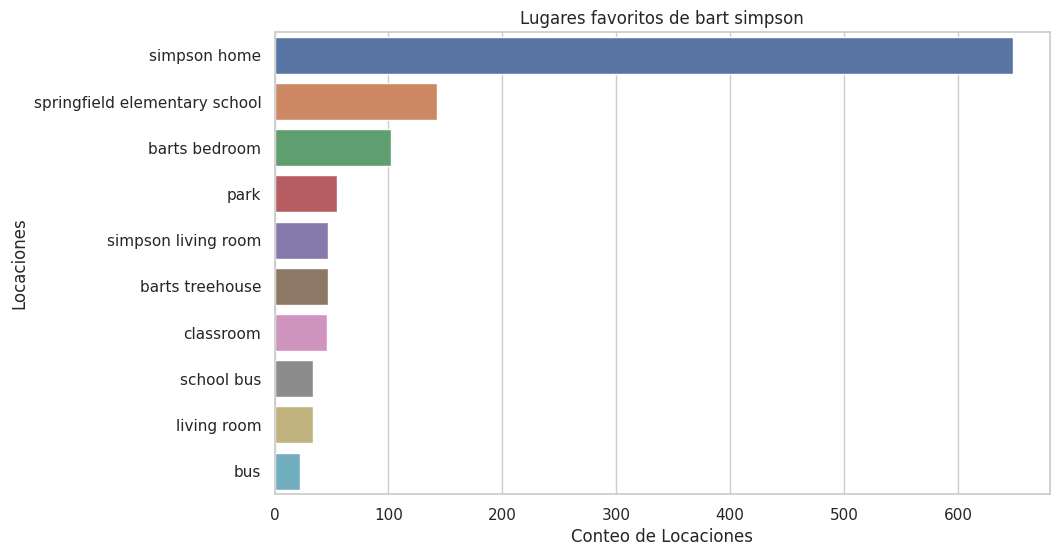

In [57]:
# Donde suceden las escenas de Bart
location_of_characters("bart simpson")

La mayoria de escenas de Bart Simpson suceden en su casa, luego en la escuela y en el parque.

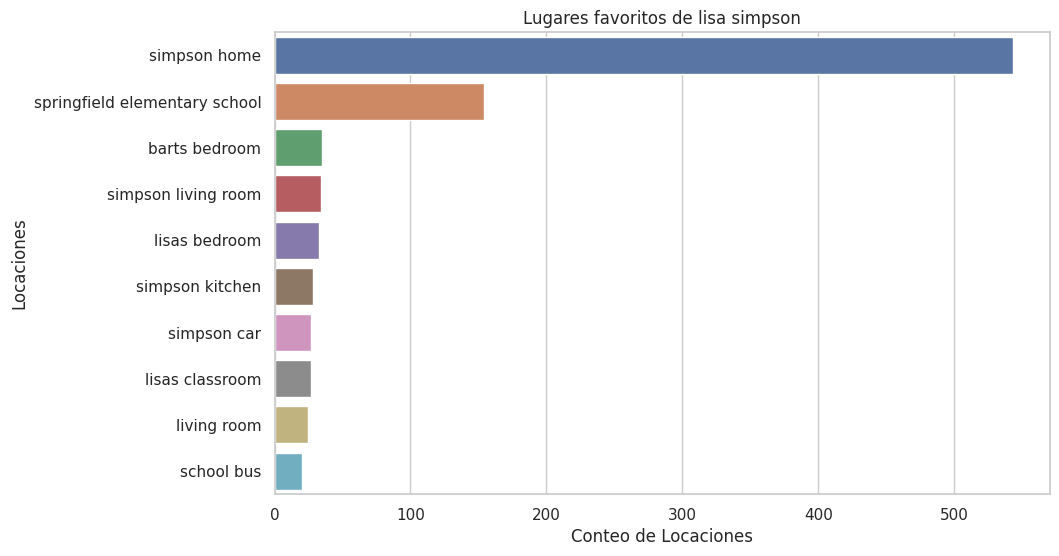

In [58]:
# Donde suceden las escenas de Lisa
location_of_characters("lisa simpson")

La mayoria de escenas de Lisa Simpson suceden en su casa, luego en la escuela y tercero en la habitacion de Bart.

Metodo FreqDist de NLTK

In [59]:
from nltk import FreqDist
fdist = FreqDist(all_words)

In [60]:
fdist.most_common(20)

[('oh', 1289),
 ('well', 1193),
 ('like', 1023),
 ('one', 959),
 ('know', 927),
 ('get', 895),
 ('homer', 787),
 ('got', 765),
 ('right', 696),
 ('bart', 665),
 ('hey', 648),
 ('go', 608),
 ('good', 569),
 ('little', 559),
 ('think', 534),
 ('see', 532),
 ('want', 525),
 ('marge', 516),
 ('man', 511),
 ('na', 509)]

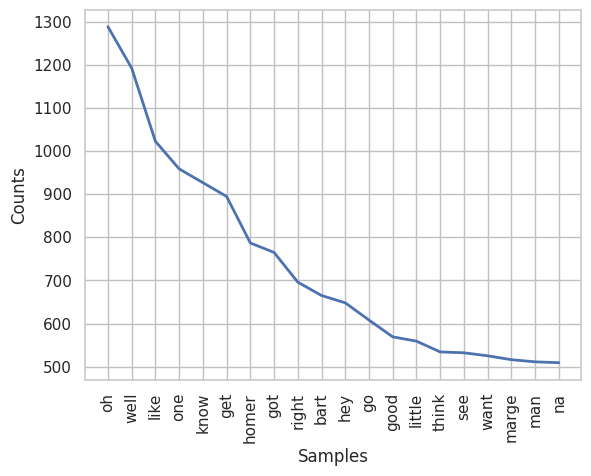

<Axes: xlabel='Samples', ylabel='Counts'>

In [61]:
fdist.plot(20)

# Segunda Parte
La idea de este analisis es comprobar si puedo predecir la valoracion de un capitulo en base a su dialogo.
Para ello voy a cargar un dataset con la valoracion imdb de los capitulos y los voy a unir con el dataset con el que venia trabajando.

In [62]:
# Cargo la base de datos con los valores
episodes = pd.read_csv('https://raw.githubusercontent.com/Havilongo/NLP/main/Simpsons/Data/simpsons_episodes.csv', index_col= [0])
print(episodes.sample())
print(episodes.shape)
print(episodes.dtypes)

        id                                          image_url  imdb_rating  \
index                                                                        
324    188  http://static-media.fxx.com/img/FX_Networks_-_...          7.6   

       imdb_votes  number_in_season  number_in_series original_air_date  \
index                                                                     
324         958.0                10               188        1997-12-21   

       original_air_year production_code  season  \
index                                              
324                 1997            5F07       9   

                              title  us_viewers_in_millions  \
index                                                         
324    Miracle on Evergreen Terrace                     9.6   

                                             video_url    views  
index                                                            
324    http://www.simpsonsworld.com/video/306881091696  1989

In [63]:
SC.shape

(23060, 9)

In [64]:
episodes_text = pd.merge(episodes, SC, left_on='id', right_on='episode_id', how='left')
episodes_text.sample(2)

id_x                                          image_url  imdb_rating  \
20795    31  http://static-media.fxx.com/img/FX_Networks_-_...          8.0   
20781    31  http://static-media.fxx.com/img/FX_Networks_-_...          8.0   

       imdb_votes  number_in_season  number_in_series original_air_date  \
20795      1257.0                18                31        1991-04-11   
20781      1257.0                18                31        1991-04-11   

       original_air_year production_code  season  ...    views    id_y  \
20795               1991            7F18       2  ...  58561.0  9226.0   
20781               1991            7F18       2  ...  58561.0  9210.0   

      episode_id  raw_character_text                  raw_location_text  \
20795       31.0     Waylon Smithers                     Burns's Office   
20781       31.0       Marge Simpson  Community College Painting Studio   

                                            spoken_words        character  \
20795  Well, she won first prize in the Springfield A...  waylon smithers   
20781  Really? You're so supportive. I wish every tea...    marge simpson   

                                location  \
20795                      burnss office   
20781  community college painting studio   

                                             normalizado  \
20795  well she won first prize in the springfield ar...   
20781  really youre so supportive i wish every teache...   

                                                  tokens  
20795  [well, first, prize, springfield, art, fair, w...  
20781   [really, supportive, wish, every, teacher, like]  

[2 rows x 23 columns]

In [65]:
# chequeo por nulos
episodes_text.shape

(23424, 23)

In [66]:
episodes_text.isna().sum()

id_x                        0
image_url                   4
imdb_rating                 3
imdb_votes                  3
number_in_season            0
number_in_series            0
original_air_date           0
original_air_year           0
production_code             0
season                      0
title                       0
us_viewers_in_millions      8
video_url                   4
views                       4
id_y                      364
episode_id                364
raw_character_text        364
raw_location_text         364
spoken_words              364
character                 364
location                  364
normalizado               364
tokens                    364
dtype: int64

In [67]:
# Tengo que Dropear los nulos
episodes_cleaned = episodes_text.dropna(subset=['spoken_words'])
episodes_cleaned.isnull().sum()

id_x                      0
image_url                 0
imdb_rating               0
imdb_votes                0
number_in_season          0
number_in_series          0
original_air_date         0
original_air_year         0
production_code           0
season                    0
title                     0
us_viewers_in_millions    3
video_url                 0
views                     0
id_y                      0
episode_id                0
raw_character_text        0
raw_location_text         0
spoken_words              0
character                 0
location                  0
normalizado               0
tokens                    0
dtype: int64

### Distribucion de los ratings

In [68]:
episodes_cleaned.imdb_rating.value_counts()

imdb_rating
6.5    2224
7.0    1914
8.2    1629
6.7    1573
6.9    1476
7.5    1227
7.8    1111
6.3     986
7.2     962
7.1     878
8.0     821
8.1     802
7.9     738
7.3     737
7.6     720
6.8     706
6.6     683
5.8     640
7.7     556
8.3     545
6.4     492
7.4     374
8.8     294
6.2     249
4.5     247
8.4     230
8.5     211
9.0      11
8.6       8
8.7       6
6.0       5
8.9       3
9.1       2
Name: count, dtype: int64

In [69]:
percent_val = (100 * episodes_cleaned.imdb_rating.value_counts()/episodes_cleaned.shape[0]).sort_index()
percent_val

imdb_rating
4.5    1.071119
5.8    2.775369
6.0    0.021683
6.2    1.079792
6.3    4.275802
6.4    2.133565
6.5    9.644406
6.6    2.961839
6.7    6.821336
6.8    3.061578
6.9    6.400694
7.0    8.300087
7.1    3.807459
7.2    4.171726
7.3    3.196010
7.4    1.621856
7.5    5.320902
7.6    3.122290
7.7    2.411101
7.8    4.817866
7.9    3.200347
8.0    3.560278
8.1    3.477884
8.2    7.064180
8.3    2.363400
8.4    0.997398
8.5    0.915004
8.6    0.034692
8.7    0.026019
8.8    1.274935
8.9    0.013010
9.0    0.047702
9.1    0.008673
Name: count, dtype: float64

Text(0, 0.5, 'Porcentaje (%)')

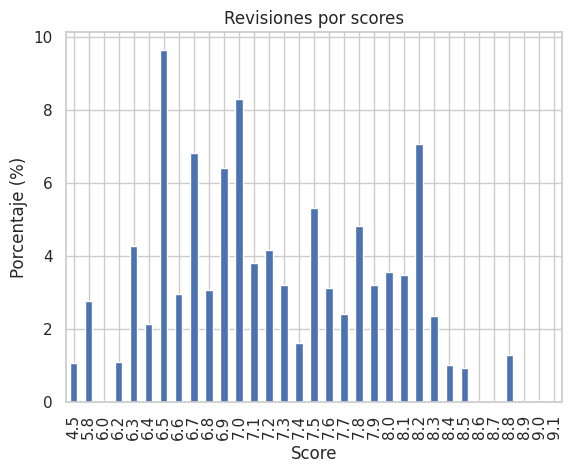

In [70]:
percent_val.plot.bar()
plt.title('Revisiones por scores')
plt.xlabel('Score')
plt.ylabel('Porcentaje (%)')

la distribucion es asimetrica, con un gran valor para los ratings de 6 a 8 y pocos en los extremos
Para propositos del analisis convertiremos todos los ratings en valores binarios con las siguientes reglas:
- ratings mayores a 7 seran convertidos a 1 (positivo)
- ratings menores a 7 seran convertidos a 0 (negativo)


In [71]:
episodes_cleaned['binario'] = np.where(episodes_cleaned.imdb_rating > 7, 1, 0)
episodes_cleaned['binario'].value_counts()

binario
1    11865
0    11195
Name: count, dtype: int64

In [72]:
episodes_cleaned[['imdb_rating','binario']]

imdb_rating  binario
0              7.4        1
1              7.4        1
2              7.4        1
3              7.4        1
4              7.4        1
...            ...      ...
23419          7.0        0
23420          7.0        0
23421          7.0        0
23422          7.0        0
23423          7.0        0

[23060 rows x 2 columns]

quedaron balanceados

In [73]:
episodes_cleaned.sample()

id_x                                          image_url  imdb_rating  \
22610   567  http://static-media.fxx.com/img/FX_Networks_-_...          6.6   

       imdb_votes  number_in_season  number_in_series original_air_date  \
22610       372.0                15               567        2015-03-01   

       original_air_year production_code  season  ...      id_y  episode_id  \
22610               2015          TABF08      26  ...  158055.0       567.0   

      raw_character_text  raw_location_text  \
22610               KEMI        Burns Manor   

                                            spoken_words  character  \
22610  I think he is a sweet, sweet man. But when I k...       kemi   

          location                                        normalizado  \
22610  burns manor  i think he is a sweet sweet man but when i kis...   

                                                  tokens binario  
22610  [think, sweet, sweet, man, kissed, forehead, r...       0  

[1 rows x 24 columns]

In [74]:
episodes_cleaned.to_csv('episodes_cleaned.csv', index = False)

#### ML

In [75]:
X=episodes_cleaned.spoken_words
y=episodes_cleaned.binario

#### Modelo usando CountVectorizer

In [76]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [77]:
from sklearn.linear_model import LogisticRegression

# Initialize the Count Vectorizer
count_vectorizer = CountVectorizer(stop_words=stop_words)

# Fit the model and transform the data
X_train_v = count_vectorizer.fit_transform(X_train)


clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_v, y_train)


LogisticRegression(max_iter=1000)

In [78]:
X_test.shape

(5765,)

In [79]:
X_test_v=count_vectorizer.transform(X_test)

In [80]:
y_pred=clf.predict(X_test_v)

In [81]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.6442


El rendimiento del modelo no es muy bueno

### Box Of Words

In [82]:
# Creacion de metodo para stemming
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()
analyzer = CountVectorizer().build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

In [83]:
# Creacion de un objeto tipo CountVectorizer
bow_counts = CountVectorizer(
    tokenizer=word_tokenize,
    stop_words=stop_words,
    ngram_range=(1, 1)
)

In [84]:
reviews_train, reviews_test = train_test_split(episodes_cleaned, test_size=0.2, random_state=0)


In [85]:
reviews_train.sample()

id_x                                          image_url  imdb_rating  \
23215   548  http://static-media.fxx.com/img/FX_Networks_-_...          7.0   

       imdb_votes  number_in_season  number_in_series original_air_date  \
23215       504.0                18               548        2014-04-13   

       original_air_year production_code  season  ...      id_y  episode_id  \
23215               2014          SABF13      25  ...  153121.0       548.0   

      raw_character_text  raw_location_text  \
23215        Adult Jenda   BART'S APARTMENT   

                              spoken_words    character         location  \
23215  Living out of a car is not camping!  adult jenda  barts apartment   

                              normalizado                  tokens binario  
23215  living out of a car is not camping  [living, car, camping]       0  

[1 rows x 24 columns]

In [86]:
X_train_bow = bow_counts.fit_transform(reviews_train.normalizado)
X_test_bow = bow_counts.transform(reviews_test.normalizado)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



In [87]:
y_train_bow = reviews_train['binario']
y_test_bow = reviews_test['binario']

In [88]:
y_test_bow.value_counts() / y_test_bow.shape[0]

binario
1    0.511925
0    0.488075
Name: count, dtype: float64

Esta bien balanceados

#### Modelo de regresion logistica

In [89]:
from sklearn.metrics import f1_score
# Entrenar el modelo
lr_model_all = LogisticRegression(C=1, solver="liblinear")
lr_model_all.fit(X_train_bow, y_train_bow)

# Predecir el output
test_pred_lr_prob = lr_model_all.predict_proba(X_test_bow)
test_pred_lr_all = lr_model_all.predict(X_test_bow)

print("F1 score: ", f1_score(y_test_bow, test_pred_lr_all))
print("Accuracy: ", accuracy_score(y_test_bow, test_pred_lr_all) * 100)

F1 score:  0.6464226289517472
Accuracy:  63.13963573287077


Usando Box of Words no mejoro el rendimiento del modelo

In [90]:
probabilities = [each[1] for each in test_pred_lr_prob]

In [91]:
reviews_test.sample()

id_x                                          image_url  imdb_rating  \
10410    18  http://static-media.fxx.com/img/FX_Networks_-_...          7.5   

       imdb_votes  number_in_season  number_in_series original_air_date  \
10410      1381.0                 5                18        1990-11-08   

       original_air_year production_code  season  ...    id_y  episode_id  \
10410               1990            7F05       2  ...  5333.0        18.0   

      raw_character_text  raw_location_text              spoken_words  \
10410      Patty Bouvier       Simpson Home  Look, he can use a horn.   

           character      location             normalizado             tokens  \
10410  patty bouvier  simpson home  look he can use a horn  [look, use, horn]   

      binario  
10410       1  

[1 rows x 24 columns]

In [92]:
predictions = pd.DataFrame()
predictions['Text'] = reviews_test['spoken_words']
predictions['Actual_Score'] = reviews_test['imdb_rating']
predictions['Sentiment_rating'] = reviews_test['binario']
predictions['Predicted_sentiment'] = test_pred_lr_all
predictions['Predicted_probability'] = probabilities

In [93]:
predictions.head(10)

Text  Actual_Score  \
17535                                I accept your whip.           6.3   
19509            What I told you was to wait in the car.           6.9   
3939   I've been on here since Chicago! I just want m...           4.5   
14241  There's gotta be a clue in here somewhere. Spa...           6.7   
5628       I don't wanna die! I wanna still be a burden!           6.8   
9281   And I'd get to take a plane there, wouldn't I,...           7.8   
8793   This is wonderful, Smithers. For once in my li...           5.8   
845                                   your mudslinger...           8.1   
12393                                       Yes, you do!           7.8   
23204  Just stick the tip of your pen in that little ...           7.0   

       Sentiment_rating  Predicted_sentiment  Predicted_probability  
17535                 0                    0               0.372999  
19509                 0                    0               0.354399  
3939                  0                    0               0.362141  
14241                 0                    1               0.685297  
5628                  0                    0               0.136149  
9281                  1                    0               0.297262  
8793                  0                    1               0.858617  
845                   1                    0               0.489210  
12393                 1                    1               0.571374  
23204                 0                    0               0.424887

In [94]:
accuracy_score(predictions['Sentiment_rating'], predictions['Predicted_sentiment'])

0.6313963573287077

In [95]:
predictions[
    predictions['Predicted_sentiment'] != predictions['Sentiment_rating']
].sort_values(by=["Predicted_probability"]).head(3)

Text  Actual_Score  \
11692  On the left is Mr. Largo, my music teacher at ...           7.5   
9076   Okay. We've eaten, and eaten well. Now, what e...           7.5   
12869  Well, it doesn't matter how you feel inside, y...           7.6   

       Sentiment_rating  Predicted_sentiment  Predicted_probability  
11692                 1                    0               0.017360  
9076                  1                    0               0.031545  
12869                 1                    0               0.034896

In [96]:
predictions.loc[11692].values

array(['On the left is Mr. Largo, my music teacher at school. He taught me that even the noblest concerto can be drained of its beauty and soul. And on the right is Bleeding Gums Murphy. He taught me that music is like a fire in your belly that comes out of your mouth, so you better stick an instrument in front of it.',
       7.5, 1, 0, 0.017360279957782918], dtype=object)

Al estar analizando cada una de las frases del capitulo, es posible que la frase en si tenga una connotacion negativa pero el capitulo es su conjunto es positivo



A continuacion voy a intentar mejorar el modelo usando n-gramas

In [97]:
bow_counts = CountVectorizer(
    tokenizer=word_tokenize,
    ngram_range=(1,4)
)

X_train_bow = bow_counts.fit_transform(reviews_train.normalizado)
X_test_bow = bow_counts.transform(reviews_test.normalizado)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



In [98]:
# Cambios en la regresión logística
# Cambio de la sanción de regularización por defecto de l2 a l1
# Cambiando el parámetro de costo C a 0.9
lr_model_all_new = LogisticRegression(C=0.9, solver="liblinear")

In [99]:
# Entrenar el modelo
lr_model_all_new.fit(X_train_bow, y_train_bow)

# Predecir resultados
test_pred_lr_prob = lr_model_all_new.predict_proba(X_test_bow)
test_pred_lr_all = lr_model_all_new.predict(X_test_bow)

print("F1 score: ", f1_score(y_test_bow, test_pred_lr_all))
print("Accuracy: ", accuracy_score(y_test_bow, test_pred_lr_all) * 100)

F1 score:  0.662422997946612
Accuracy:  64.35385949696443


Mejoro muuuy poco

In [100]:
lr_weights = pd.DataFrame(list(
    zip(
        bow_counts.get_feature_names_out(),
        lr_model_all_new.coef_[0])
    ),
    columns=['words','weights']
)

lr_weights.sort_values(['weights'],ascending = False)[:15]

words   weights
119324       hmmm  1.539465
25654      arrrgh  1.537160
31275      barney  1.486604
11141          ah  1.393319
65104        dear  1.262601
164739     little  1.213421
51475       carls  1.184722
245330        sir  1.178203
151870     just a  1.163635
318390  well okay  1.157709
180071     mmmhmm  1.149383
218087      patty  1.146677
51411        carl  1.142273
70576         dog  1.121294
31379        bart  1.097956

In [101]:
lr_weights.sort_values(['weights'],ascending = False)[-15:]

words   weights
268373     thats good -0.981865
42908        broccoli -1.010425
221289        plastic -1.048681
260113        sweetie -1.055187
116301        hey dad -1.057708
217623          party -1.068900
59064      convention -1.108146
31431       bart bart -1.120609
184466          music -1.121053
304796             um -1.184337
173395           mary -1.239959
246171        skinner -1.256746
178613       milhouse -1.485916
205974        oh yeah -1.554290
120741  homer simpson -1.560509

El analisis nos da como resultado que palabras como fiesta o el nombre de homero tienen connotaciones negativas. Algo que resulta confuso

### Vectorizacion TF-IDF

In [102]:
# Cree un vectorizador: aún alimentamos nuestras stopwords, aunque
# estos son menos relevantes ahora ya que TF-IDF los ponderaría menos
# de todas formas.
tfidf_counts = TfidfVectorizer(
    stop_words=stop_words,
    ngram_range=(1,1)
)

X_train_tfidf = tfidf_counts.fit_transform(reviews_train.normalizado)
X_test_tfidf = tfidf_counts.transform(reviews_test.normalizado)

##### Regresion logistica

In [103]:
# Crear el clasificador
lr_model_tf_idf = LogisticRegression(solver="liblinear")

# Entrenar
lr_model_tf_idf.fit(X_train_tfidf, y_train_bow)

# Predecir
test_pred_lr_prob = lr_model_tf_idf.predict_proba(X_test_tfidf)
test_pred_lr_all = lr_model_tf_idf.predict(X_test_tfidf)

## Evaluar el modelo
print("F1 score: ",f1_score(y_test_bow, test_pred_lr_all))
print("Accuracy: ", accuracy_score(y_test_bow, test_pred_lr_all) * 100)

F1 score:  0.6430230103440997
Accuracy:  63.3347788378144


**Reflexion**: La regresion Logistica con el metodo TF-IDF sigue siendo bajo. En un principio crei que rendiria mejor al tratarse de una serie con muchas frases repetidas por los personales a lo largo de la serie

TD-IDF con n-gramas

In [104]:
tfidf_counts = TfidfVectorizer(
    stop_words=stop_words,
    ngram_range=(1,3)
)

X_train_tfidf = tfidf_counts.fit_transform(reviews_train.normalizado)
X_test_tfidf = tfidf_counts.transform(reviews_test.normalizado)

In [105]:
# definiendo la clase del modelo
lr_model_tf_idf_new = LogisticRegression(solver="liblinear")

# Entrenar
lr_model_tf_idf_new.fit(X_train_tfidf, y_train_bow)

# Predecir
test_pred_lr_prob = lr_model_tf_idf_new.predict_proba(X_test_tfidf)
test_pred_lr_all = lr_model_tf_idf_new.predict(X_test_tfidf)

# Evaluar el modelo
print("F1 score: ",f1_score(y_test_bow, test_pred_lr_all))
print("Accuracy: ", accuracy_score(y_test_bow, test_pred_lr_all)*100)

F1 score:  0.6455617628801987
Accuracy:  62.857762359063315


Mejoro pero muuuy poquito

In [106]:
lr_weights = pd.DataFrame(
    list(
        zip(tfidf_counts.get_feature_names_out(), lr_model_tf_idf_new.coef_[0])
    ),
    columns=['words','weights']
)

lr_weights.sort_values(['weights'],ascending = False)[:10]

words   weights
82653         oh  2.628031
1299          ah  2.553604
106420       sir  2.290915
7130        bart  2.267779
52651       hmmm  2.166214
105656   simpson  2.018015
27098        dog  1.939421
7060      barney  1.883639
137314      yeah  1.814275
107769  smithers  1.790753

In [107]:
lr_weights.sort_values(['weights'],ascending = False)[-10:]

words   weights
87573      party -1.389322
107021   skinner -1.420209
43575        god -1.454091
3027     another -1.501001
115174   sweetie -1.520951
73219       mary -1.611150
78661      music -1.648442
83694    oh yeah -1.731657
125918        um -1.911711
75227   milhouse -2.201363

## Analisis con todos los dialogos en cada capitulo

In [108]:
# Agrupar por 'episode_id' y concatenar las cadenas en 'spoken_words'
result = SC.groupby('episode_id')['spoken_words'].apply(' '.join).reset_index()

result

episode_id                                       spoken_words
0             1  Ooo, careful, Homer. There's no time to be car...
1             2  I'll pay! How much? Come on, Mom. Yeah, Mom, h...
2             3  We're radioactive! Of course we're hot. Now, c...
3             4  Oh, yeah? Yeah! Oh, yeah? Yeah! Oh, yeah? Yeah...
4             5  Here? These are for Lisa's class. Do I smell c...
..          ...                                                ...
231         564  Whoa! Looks like our bird house is benefitting...
232         565  AND OUR DENTISTS ARE ALL SELF-TAUGHT And I reg...
233         566  HIS DAUGH-TER LISA! MARGE, HIS WIFE! HERE'S HO...
234         567  Forty-three is missing again! How come there's...
235         568  You never let me tell! Love you guys! Jet pack...

[236 rows x 2 columns]

In [109]:
data = pd.merge(result, episodes_cleaned, left_on='episode_id', right_on='id_x', how='left')
data.sample()

episode_id_x                                     spoken_words_x  id_x  \
18723           547  Ho-mer, Ho-mer-- Hey-hey, what-- Cleats. Homie...   547   

                                               image_url  imdb_rating  \
18723  http://static-media.fxx.com/img/FX_Networks_-_...          6.5   

       imdb_votes  number_in_season  number_in_series original_air_date  \
18723       415.0                17               547        2014-04-06   

       original_air_year  ...      id_y  episode_id_y raw_character_text  \
18723               2014  ...  152986.0         547.0      Marge Simpson   

       raw_location_text                      spoken_words_y      character  \
18723       Simpson Home  All right, you've made your point.  marge simpson   

           location                      normalizado  \
18723  simpson home  all right youve made your point   

                            tokens binario  
18723  [right, youve, made, point]       0  

[1 rows x 26 columns]

In [110]:
data1 = data[['spoken_words_x', 'binario', 'imdb_rating']]
data1 = data1.drop_duplicates()

In [111]:
data1.shape

(236, 3)

In [112]:
data1.sample(10)

spoken_words_x  binario  imdb_rating
8680   No cops in sight. If I'm gonna save that clerk...        1          8.0
21770  I have such a big ass. WALKIN' DOWN A CORRIDOR...        1          7.3
17606  Neptune. Eighth planet from the sun. A mystery...        0          6.7
333    I'll pay! How much? Come on, Mom. Yeah, Mom, h...        1          7.8
8681               This test is boring. What else is on?        0          7.0
8693   Edwina, my slowly-opening flower, I'm shippin'...        1          7.1
8897   Half-day, eh? My fellow Wildcats... My name is...        0          7.0
19458  Our Lord, Buddha, says the secret of existence...        0          6.7
17377  Where's my money? ...And it's for all these re...        0          6.4
8820   With you, baby, Top Ramen tastes like Cup O' N...        0          6.3

In [113]:
X=data1.spoken_words_x
y=data1.binario

In [114]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [115]:
from sklearn.linear_model import LogisticRegression

# Initialize the Count Vectorizer
count_vectorizer = CountVectorizer(stop_words=stop_words)

# Fit the model and transform the data
X_train_v = count_vectorizer.fit_transform(X_train)


clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_v, y_train)

LogisticRegression(max_iter=1000)

In [116]:
X_test.shape

(59,)

In [117]:
X_test_v=count_vectorizer.transform(X_test)

In [118]:
y_pred=clf.predict(X_test_v)

In [119]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.6949


Mejoro bastante el modelo, aunque solamente testeo con 59 muestras